## 1. Load data from database

In [1]:
import pandas as pd
import sqlite3

path = "/Users/pavel/PycharmProjects/stock-market-app/src/financial_data.db"

sqlFinancials  = """select *
from balance_sheet bs
left join pnl p
on bs.ticker = p.ticker
and bs.type = p.type
and bs.fiscalDateEnding = p.fiscalDateEnding
left join cash_flow cf
on bs.ticker = cf.ticker
and bs.type = cf.type
and bs.fiscalDateEnding = cf.fiscalDateEnding
"""
conn = sqlite3.connect(path)
financials_db = pd.read_sql(sqlFinancials, conn)
conn.close()

financials_db = financials_db.loc[:, ~financials_db.columns.duplicated()]

sqlCandles = "select * from candles"
conn = sqlite3.connect(path)
candles_db = pd.read_sql(sqlCandles, conn)
conn.close()

# Counting forward looking 90-days average
candles = candles_db[['date_time','ticker', 'close']].copy()
candles = candles.sort_values(['ticker', 'date_time'])
candles['avg_90d'] = (
    candles.groupby('ticker')['close']
    .apply(lambda x: x.shift(-90).rolling(90).mean())
    .reset_index(level=0, drop=True)
)


# Merge financials and stock prices data
candles['date_time'] = pd.to_datetime(candles['date_time'])

financials_db['fiscalDateEnding'] = pd.to_datetime(financials_db['fiscalDateEnding'])

candles = candles.sort_values(by='date_time')
financials_db = financials_db.sort_values(by='fiscalDateEnding')

financials_data = pd.merge_asof(
    financials_db,
    candles,
    left_on='fiscalDateEnding',
    right_on='date_time',
    by='ticker',
    direction='nearest'  # use nearest valus
)

financials = financials_data[financials_data['type'] == 'quarterly'].copy()

## 2. Creating dataset

In [2]:
# Create features:
# - ebitda growth: ebitda_t / ebitda_t-1
financials['ebitda_g'] = financials['ebitda'] / financials['ebitda'].shift(1)

# - sales growth: sales_t / sales_t-1
financials['sales_g'] = financials['totalRevenue'] / financials['totalRevenue'].shift(1)
# - net_income growth: net_income_t / net_income_t-1
financials['net_income_g'] = financials['netIncome'] / financials['netIncome'].shift(1)

# - ebitda margin: ebitda / sales
financials['ebitda_margin'] = financials['ebitda'] / financials['totalRevenue']

# - ebitda margin growth: em_t / em_t-1
financials['ebitda_margin_g'] = financials['ebitda_margin'] / financials['ebitda_margin'].shift(1)

# - debt-to-ebitda
financials['ebitda_ltm'] = financials['ebitda'].rolling(4).sum()
financials['debt_ebitda'] = (financials['shortTermDebt'] + financials['longTermDebt']) / financials['ebitda_ltm']

# - ebitda_ltm growth
financials['ebitda_ltm_g'] = financials['ebitda_ltm'] / financials['ebitda_ltm'].shift(1)

# - ebitda_ltm growth
financials['avg_90d_g'] = financials['avg_90d'] / financials['avg_90d'].shift(1)

In [3]:
# input parameters
selected_tickers = financials['ticker'].unique()
features = ['ebitda_g', 'sales_g', 'net_income_g', 'ebitda_margin',
                   'ebitda_margin_g', 'ebitda_ltm_g', 'debt_ebitda']
target = 'avg_90d_g'
start_date = '2019-01-01'
end_date = '2024-12-31'

In [4]:
# creating dataset
data = financials[(financials['fiscalDateEnding'] >= start_date) &
                    (financials['fiscalDateEnding'] <= end_date)][['avg_90d', 'avg_90d_g', 'ticker', 'fiscalDateEnding', 'ebitda', 'totalRevenue', 'netIncome', 'ebitda_g', 'sales_g', 'net_income_g', 'ebitda_margin',
                   'ebitda_margin_g', 'ebitda_ltm', 'ebitda_ltm_g', 'debt_ebitda']].copy()

## 3. Analysis of dataset

Text(0.5, 1.0, 'Missing value in the dataset')

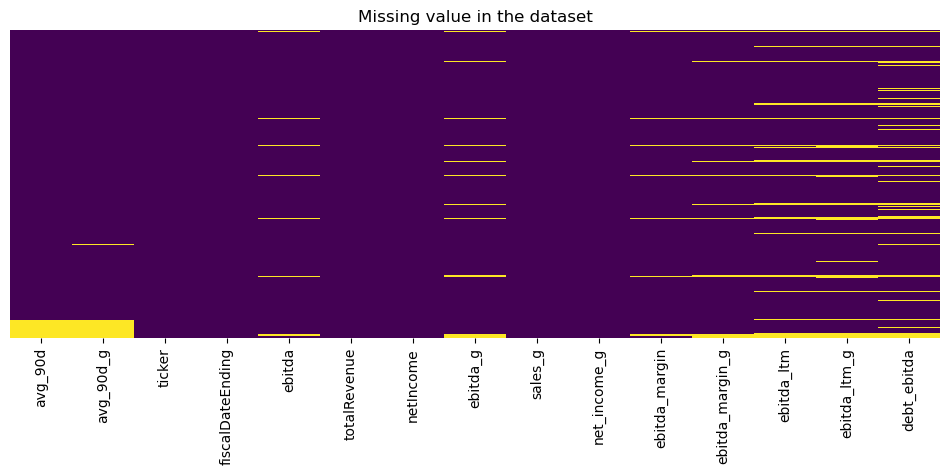

In [5]:
# check for missing values
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(12,4))
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset')

In [6]:
data_without_nan = data.dropna().copy()

In [ ]:
# correlation analysis
for ticker in selected_tickers:
    corr = data[(data['ticker'] == ticker)][features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap='Wistia', annot=True, fmt=".2f", cbar=True)
    plt.title(f'Correlation matrix for {ticker}')
    plt.show()

In [ ]:
# analyze distribution
for ticker in selected_tickers:
    for financial in features:
        f= plt.figure(figsize=(12,4))
        ax=f.add_subplot(121)
        sns.distplot(data[financial],bins=50,color='r',ax=ax)
        ax.set_title(f'Distribution of {financial} for {ticker}')

        ax=f.add_subplot(122)
        sns.distplot(np.log10(data[financial]),bins=40,color='b',ax=ax)
        ax.set_title(f'Distribution of {financial} in $log$ sacle for {ticker}')
        ax.set_xscale('log')

## 4. Analysis of correlations between the target variable and the features

In [ ]:
# create a scatter diagram
def scatterPlotForTicker(data, tickers, features, target):
    for ticker in tickers:
        for feature in features:
            plt.figure()
            plt.scatter(data[(data['ticker'] == ticker)][feature], data[(data['ticker'] == ticker)][target])
            plt.title(f'Scatter Plot for {ticker} - {feature} vs {target}')
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.grid(True)
            plt.show()

In [ ]:
scatterPlotForTicker(data_without_nan, selected_tickers, features, target)

In [ ]:
def correlationTableTickers(data, features, target, tickers):
    correlation_results = pd.DataFrame(columns=['Ticker', 'Feature', 'Correlation with Target'])
    for ticker in tickers:
        ticker_data = data[data['ticker'] == ticker]
        if not ticker_data.empty:
            for feature in features:
                correlation = ticker_data[feature].corr(ticker_data[target])
                new_row = pd.DataFrame({'Ticker': [ticker], 'Feature': [feature], 'Correlation with Target': [correlation]})
                correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)
    correlation_results = correlation_results.sort_values(by='Correlation with Target', ascending=False)
    return correlation_results

In [ ]:
scatterPlotForTicker(data_without_nan, ['KO', 'ACN', 'AMD', 'ASML', 'NKE', 'MU', 'ASML', 'CMCSA', 'UPS', 'ET', 'IBM', 'COP', 'QCOM'], 
                      ['ebitda_g', 'sales_g', 'ebitda_ltm_g'], target)

In [7]:
# tickers for model 'KO', 'COP', 'IBM', 'CMCSA', 'QCOM', 'UPS'
# delete outliers
data_clean = data_without_nan[
    (data_without_nan['ticker'].isin(['KO', 'COP', 'IBM', 'CMCSA', 'QCOM', 'UPS'])) &
    (
        ((data_without_nan['ticker'] == 'KO') & (data_without_nan['avg_90d_g'] < 3)) |
        ((data_without_nan['ticker'] == 'COP') & (data_without_nan['avg_90d_g'] < 4)) | 
        ((data_without_nan['ticker'] == 'IBM') & (data_without_nan['ebitda_g'] < 10)) | 
        ((data_without_nan['ticker'] == 'CMCSA') & (data_without_nan['ebitda_g'] > -5)) |
        ((data_without_nan['ticker'] == 'QCOM')) |
        ((data_without_nan['ticker'] == 'UPS'))
    )
].copy()

In [ ]:
scatterPlotForTicker(data_clean, ['KO', 'COP', 'IBM', 'CMCSA', 'QCOM', 'UPS'], 
                      ['ebitda_g', 'sales_g', 'ebitda_ltm_g'], target)

## 5. Linear regression model

In [11]:
tickers_model = ['KO', 'COP', 'IBM', 'CMCSA', 'QCOM', 'UPS']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

for ticker in tickers_model:
    df = data_clean[data_clean['ticker'] == ticker]
    X = df[['sales_g', 'ebitda_g', 'net_income_g', 'ebitda_ltm_g']]
    y = df['avg_90d_g']
    model = LinearRegression()
    results = model.fit(X, y)
    pred = model.predict(X)
    print(f'Ticker: {ticker} R2: {r2_score(y, pred)}')

In [ ]:
for ticker in tickers_model:
    df = data_clean[data_clean['ticker'] == ticker]
    X = df[['sales_g', 'ebitda_g', 'net_income_g']]
    y = df['avg_90d_g']
    model = LinearRegression()
    results = model.fit(X, y)
    pred = model.predict(X)
    print(f'Ticker: {ticker} R2: {r2_score(y, pred)}')